# Goals
- Get equal weight version of the index fund SPDR. SPDR is a market cap-weighted (the higher the market cap, the higher asset weight)

In [1]:
import numpy as np
import pandas as pd
import requests # api requests
import xlsxwriter # excel
from tqdm import tqdm # progress bar
from time import sleep
import math
import csv
import pprint
from config import API_KEY

# Get Listing and Add-Deletions
- Gets listing, with other data like sector etc. 
- Gets lists recent additions and deletions

In [65]:
# read 500 list stock
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
listing = wiki[0]
listing.to_csv('s&p-list.csv', index=False)
add_del = wiki[1]
add_del.to_csv('s&p-add-del.csv', index=False)

# add symbols for download rest of data
symbols = listing['Symbol'].to_list()

# Get Price data
- Getting recent closing data (previous day)

In [222]:
pbar = tqdm(total=len(symbols))
price_cols = ['Ticker', 'Volume', 'Volume Weighted Avg', 'Open', 'Close', 'High',
                'Low', 'Timestamp', 'No. Transactions']
adjusted = 'false' # adjusted for splits
price_data= pd.DataFrame()
for symbol in symbols:
        new = requests.get(f'https://api.polygon.io/v2/aggs/ticker/{symbol}/prev?adjusted={adjusted}&apiKey={API_KEY}').json()
        new = pd.DataFrame(new['results'])
        price_data = pd.concat([price_data, new], axis=0)
        pbar.update(1)
pbar.close()
price_data.columns = price_cols
price_data.to_csv('s&p-price-data.csv', index=False)

# Get Financial data from stocks

In [155]:
pbar = tqdm(total=len(symbols))
fin_data = pd.DataFrame()
for symbol in symbols:
        new = requests.get(f'https://api.polygon.io/v3/reference/tickers/{symbol}?apiKey={API_KEY}').json()
        new = pd.DataFrame(new).T#[fin_headers]
        new = new.drop(labels=['request_id', 'status'], axis=0)
        fin_data = pd.concat([fin_data, new])
        pbar.update(1)
pbar.close()
fin_data.to_csv('s&p-fin-data.csv', index=False)

# Retrieve Saved Data

In [3]:
listing = pd.read_csv('s&p-list.csv')
add_del = pd.read_csv('s&p-add-del.csv')
price_data = pd.read_csv('s&p-price-data.csv')
fin_data = pd.read_csv('s&p-fin-data.csv')

# Inspect Data

In [4]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   SEC filings            503 non-null    object
 3   GICS Sector            503 non-null    object
 4   GICS Sub-Industry      503 non-null    object
 5   Headquarters Location  503 non-null    object
 6   Date first added       458 non-null    object
 7   CIK                    503 non-null    int64 
 8   Founded                503 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.5+ KB


## Industry percentage
- Trying to find the diversity in the portfolio sector-wise

<AxesSubplot:>

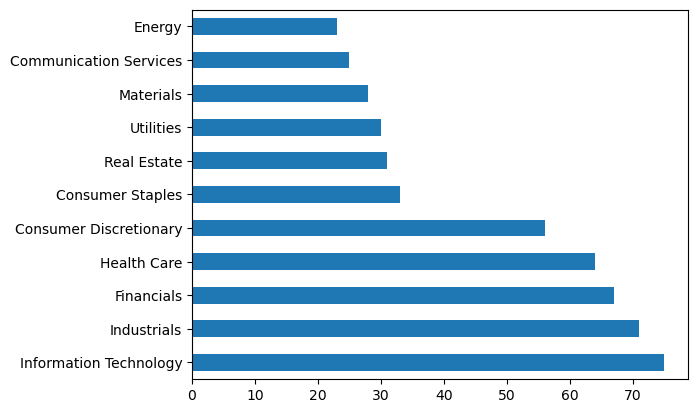

In [10]:
headers = ['GICS Sector', 'GICS Sub-Industry']
listing[headers[0]].value_counts().plot(kind='barh')

<AxesSubplot:>

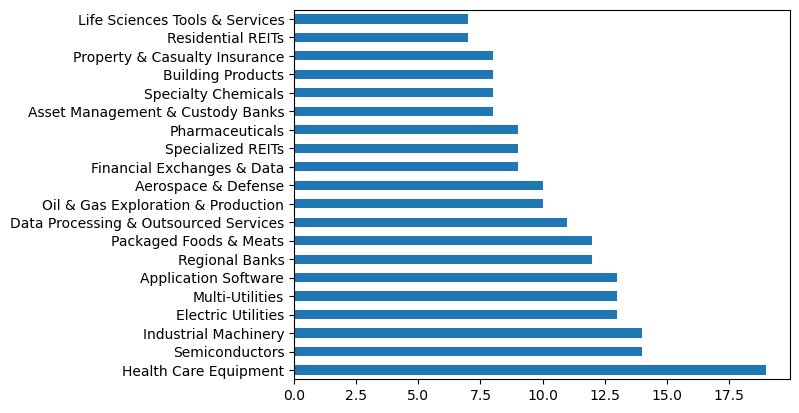

In [14]:
listing[headers[1]].value_counts().iloc[:20].plot(kind='barh')